
# E4 Preprocessing and data modelling

In [18]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Signal processing stuff
import scipy.signal as signal
import scipy.fftpack as fftpack
import scipy.stats as stats
# Machine learning stuff
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
# Hampel filter from sktime
from sktime.transformations.series.outlier_detection import HampelFilter
from sktime.transformations.series.impute import Imputer
import math
import os


In [19]:
# Definitions
dataset_dir = '../../original_dataset/'
PERSONS = 17
acceleration_data_loc = dataset_dir + 'P{:02d}/E4/ACC.csv'
VO2_data_loc = dataset_dir + 'P{:02d}/VO2/DataAverage.csv'
# Exercise lasts for 30 minutes
duration_of_exercise = 30 * 60
WINDOW_SIZE = 320

In [43]:
def load_acc_data(person):
    data = pd.read_csv(acceleration_data_loc.format(person))
    return data
def load_vo2_avg_data(person):
    data = pd.read_csv(VO2_data_loc.format(person))
    return data

def outlier_handling(data):
    # This method uses Hampel filter to detect outliers, and sktime's Imputer to replace them
    # Hampel filter
    # Define the window size
    window_size = 32 * 5
    # Define the number of standard deviations
    n_std = 2
    for channel in ['X', 'Y', 'Z']:
        # Use sktime's Hampel filter to detect outliers
        hampel_filter = HampelFilter(window_length=window_size, n_sigma=n_std, return_bool=False)
        # Apply the filter to the data
        y_hat = hampel_filter.fit_transform(data[channel].to_numpy())
        # Imputer
        # Create the sktime imputer
        imputer = Imputer(method="drift")
        # Apply the imputer to the data
        y_hat = imputer.fit_transform(y_hat)
        # Replace the original data with the filtered and imputed data
        data[channel] = y_hat
        
        
    return data

def sync_acc_with_VO2(person, handle_outliers=False):
    e4_data = load_acc_data(person)
    # Timestamp is first column
    E4_start_timestamp_num = e4_data.columns[0]
    E4_start_timestamp = pd.to_datetime(E4_start_timestamp_num, unit='s')
    # Rename column
    e4_data.columns = ['X', 'Y', 'Z']
    # First row of e4 data is the sample rate number, identical for all three channels. Take it and crop the rest
    sample_rate = e4_data['X'][0]
    e4_data = e4_data[1:]
    max_time = len(e4_data) / sample_rate

    # Handle outliers
    if handle_outliers:
        e4_data = outlier_handling(e4_data)

    # Get VO2 data
    VO2_average_data = load_vo2_avg_data(person)
    # Get the first timestamp from VO2 data column 'Time', which is a datetime
    VO2_timestamp = VO2_average_data['Time'].iloc[0]
    VO2_timestamp = pd.to_datetime(VO2_timestamp)

    # # Plot the E4 data, with a vertical line at the start of the VO2 data, and another at the end of the VO2 data
    # plt.figure(figsize=(10, 5))
    # plt.plot(e4_data['X'], label='X')
    # plt.plot(e4_data['Y'], label='Y')
    # plt.plot(e4_data['Z'], label='Z')
    # e4_and_vo2_time_diff = (E4_start_timestamp - VO2_timestamp).total_seconds()
    # e4_and_vo2_time_diff = abs(e4_and_vo2_time_diff)
    # print("E4 and VO2 time difference: ", e4_and_vo2_time_diff)
    # plt.axvline(x=e4_and_vo2_time_diff, color='r', linestyle='--', label='VO2 start')
    # plt.axvline(x=e4_and_vo2_time_diff + duration_of_exercise * sample_rate, color='g', linestyle='--', label='VO2 end')
    # plt.xlabel('Time [s]')
    # plt.ylabel('Acceleration [g]')
    # plt.legend()
    # plt.title('E4 Acceleration Data')
    # plt.show()
    
    

    # If timestamps do not match, then cut the start of the HR data to match the start of the VO2 data
    if E4_start_timestamp != VO2_timestamp:
        total_seconds = (E4_start_timestamp - VO2_timestamp).total_seconds()
        # Cut the start of the HR data to match the start of the VO2 data
        e4_data = e4_data.iloc[int(total_seconds):, :]
        max_time = len(e4_data) / sample_rate
        # Reset the time array
        time = np.linspace(0, max_time, len(e4_data))
    
    # If the E4 data is still longer than VO2 data, then cut the end of the E4 data to match the end of the VO2 data
    if max_time > duration_of_exercise:
        e4_data = e4_data.iloc[:int(duration_of_exercise * sample_rate), :]
        time = np.linspace(0, duration_of_exercise, len(e4_data))
        max_time = len(e4_data) / sample_rate

    # # Plot the data
    # plt.figure()
    # plt.plot(time, e4_data['X'], label='X')
    # plt.plot(time, e4_data['Y'], label='Y')
    # plt.plot(time, e4_data['Z'], label='Z')
    # plt.xlabel('Time [s]')
    # plt.ylabel('Acceleration [g]')
    # plt.legend()
    # plt.title('E4 Acceleration Data')
    # plt.show()

    # decimate each second in e4 data, reduce the sample rate to 1 Hz
    e4_data = e4_data.iloc[::int(sample_rate)]
    # Move the indices to start from 0
    e4_data.reset_index(drop=True, inplace=True)

    # Create Time array of DateTime objects from the start timestamp to the end timestamp
    time = np.linspace(round(float(E4_start_timestamp_num)), round(float(E4_start_timestamp_num) + float(max_time)), round(max_time))
    time = pd.to_datetime(time, unit='s')

    # If e4 data is longer than the generated time, add the difference to the time array
    while len(time) < len(e4_data):
        time = np.append(time, time[-1]+ pd.to_timedelta(1, unit='s'))
    e4_data['Time'] = time

    # Now create new time array in seconds from the start timestamp
    time_seconds = np.linspace(0, round(max_time), round(max_time))

    # If e4 data is longer than the generated time, add the difference to the time array
    while len(time_seconds) < len(e4_data):
        time_seconds = np.append(time_seconds, time_seconds[-1] + 1)
    # Round each value to the 1 decimal place and add 1 to each value
    time_seconds = np.round(time_seconds, 1)+1
    e4_data['Time[s]'] = time_seconds

    # Now create delta datetime
    time_delta = np.linspace(0, max_time, round(max_time))
    time_delta = pd.to_datetime(time_delta, unit='s')

    # If e4 data is longer than the generated time, add the difference to the time array
    while len(time_delta) < len(e4_data):
        time_delta = np.append(time_delta, time_delta[-1] + pd.to_timedelta(1, unit='s'))
    e4_data['Delta_time'] = time_delta
    return e4_data, VO2_average_data

sync_acc_with_VO2(1)

C:\Users\tiitu\AppData\Local\Temp\ipykernel_18468\290912491.py:35: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  E4_start_timestamp = pd.to_datetime(E4_start_timestamp_num, unit='s')


(      X     Y     Z                 Time  Time[s]                  Delta_time
 0   9.0  54.0  -9.0  1638550664000000000      1.0                           0
 1  45.0  32.0  57.0  1638550666000000000      3.0                  2343750000
 2  40.0  41.0  28.0  2021-12-03 16:57:47      4.0  1970-01-01 00:00:03.343750,
       Time[s] Time[hh:mm:ss]  VO2[mL/kg/min]  VO2[mL/min]  HR[bpm]  Rf[bpm]  \
 0           1       00:00:01            0.00         0.00      101     0.00   
 1           2       00:00:02            0.00         0.00      101     0.00   
 2           3       00:00:03            6.81       470.17      101    20.75   
 3           4       00:00:04            6.81       470.17      100    20.75   
 4           5       00:00:05            7.12       491.33      100    18.55   
 ...       ...            ...             ...          ...      ...      ...   
 1798     1799       00:29:59           13.34       920.33      167    29.12   
 1799     1800       00:30:00           13.

C:\Users\tiitu\AppData\Local\Temp\ipykernel_18468\4170930186.py:35: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  E4_start_timestamp = pd.to_datetime(E4_start_timestamp_num, unit='s')


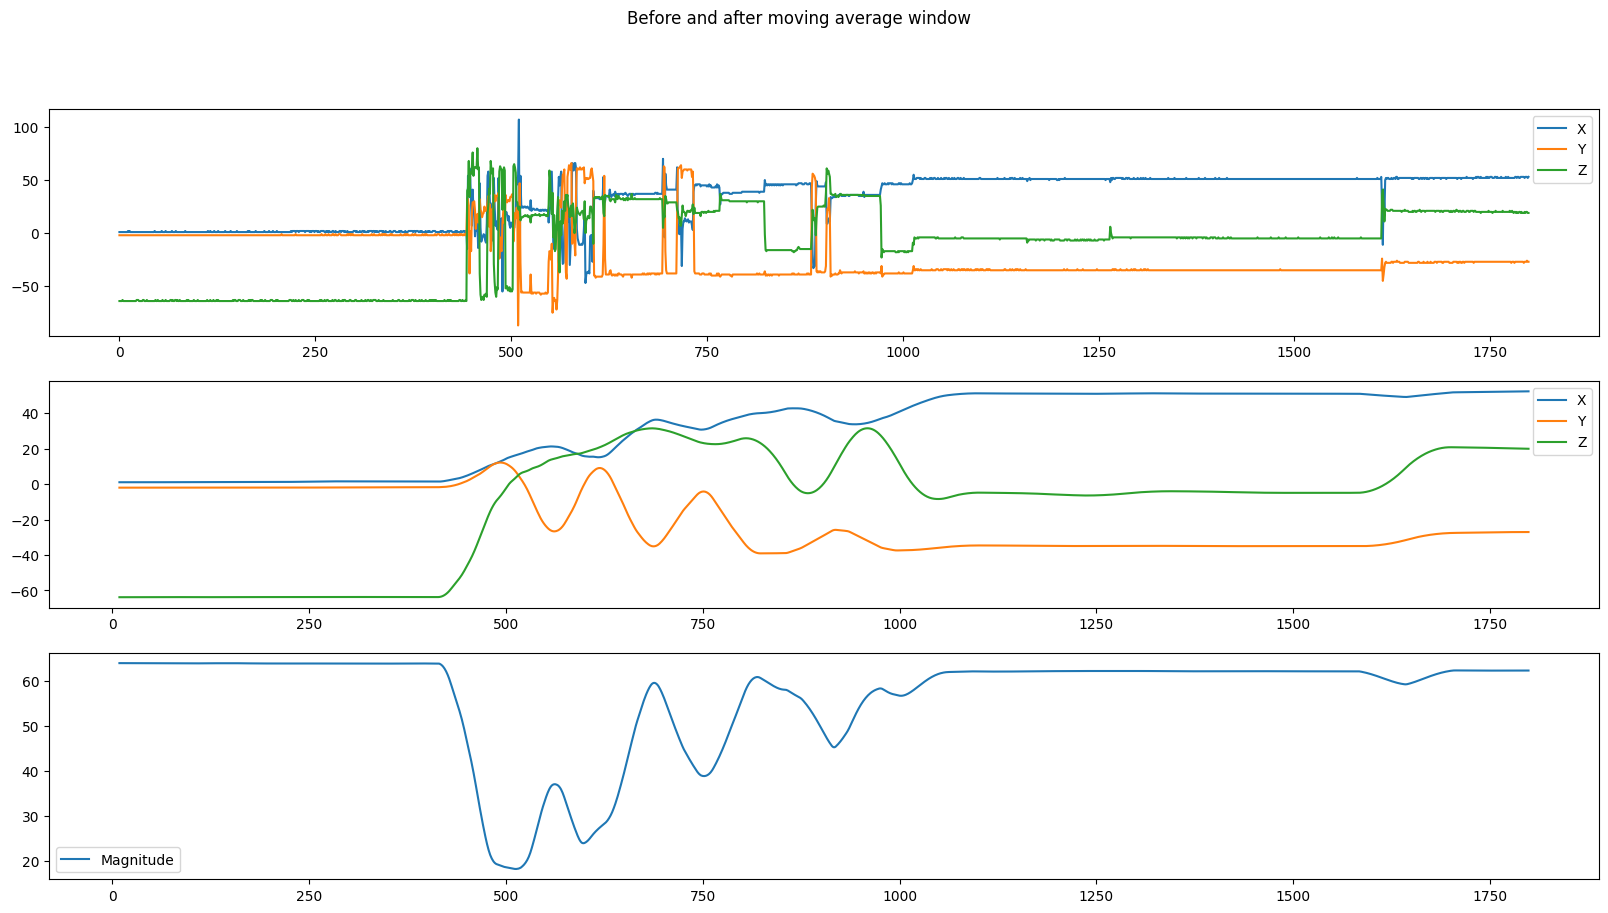

In [25]:
# Central moving average window of 1 minute
def central_moving_average(data, window_size, plot=False, person=None):
    # If plot, plot the data before and after moving average
    if plot:
        plt.figure()
        plt.plot(data['X'], label='X')
        plt.plot(data['Y'], label='Y')
        plt.plot(data['Z'], label='Z')
        plt.xlabel('Time [s]')
        plt.ylabel('Acceleration [g]')
        plt.legend()
        if person:
            plt.title(f'E4 Acceleration Data for person {person}')
        else:
            plt.title('E4 Acceleration Data')
        plt.show()
    data['X'] = data['X'].rolling(window=window_size, min_periods=1, center=True).mean()
    data['Y'] = data['Y'].rolling(window=window_size, min_periods=1, center=True).mean()
    data['Z'] = data['Z'].rolling(window=window_size, min_periods=1, center=True).mean()
    first = lambda x: x.iloc[0]
    data = data.rolling(window=window_size, min_periods=10).agg({'X': 'mean', 'Y': 'mean', 'Z': 'mean', 'Time[s]': first})
    if plot:
        plt.figure()
        plt.plot(data['X'], label='X MAW')
        plt.plot(data['Y'], label='Y MAW')
        plt.plot(data['Z'], label='Z MAW')
        plt.xlabel('Time [s]')
        plt.ylabel('Acceleration [g]')
        plt.legend()
        if person:
            plt.title(f'E4 Acceleration Data for person {person} after moving average window')
        else:
            plt.title('E4 Acceleration Data after moving average window')
        plt.show()
    return data

def compute_ACC_magnitude(data):
    return np.sqrt(data['X']**2 + data['Y']**2 + data['Z']**2)

e4_data, VO2_data = sync_acc_with_VO2(5)
import copy
e4_data_maw = copy.deepcopy(e4_data)
e4_data_maw = central_moving_average(e4_data_maw, 60)
e4_data_mag = compute_ACC_magnitude(e4_data_maw)
e4_data_maw['Magnitude'] = e4_data_mag
# Plot both side by side
fig, axs = plt.subplots(3, figsize=(20, 10))
fig.suptitle('Before and after moving average window')
axs[0].plot(e4_data['X'], label='X')
axs[0].plot(e4_data['Y'], label='Y')
axs[0].plot(e4_data['Z'], label='Z')
axs[1].plot(e4_data_maw['X'], label='X')
axs[1].plot(e4_data_maw['Y'], label='Y')
axs[1].plot(e4_data_maw['Z'], label='Z')
axs[2].plot(e4_data_mag, label='Magnitude')
axs[0].legend()
axs[1].legend()
axs[2].legend()
plt.show()

C:\Users\tiitu\AppData\Local\Temp\ipykernel_18468\780225939.py:35: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  E4_start_timestamp = pd.to_datetime(E4_start_timestamp_num, unit='s')


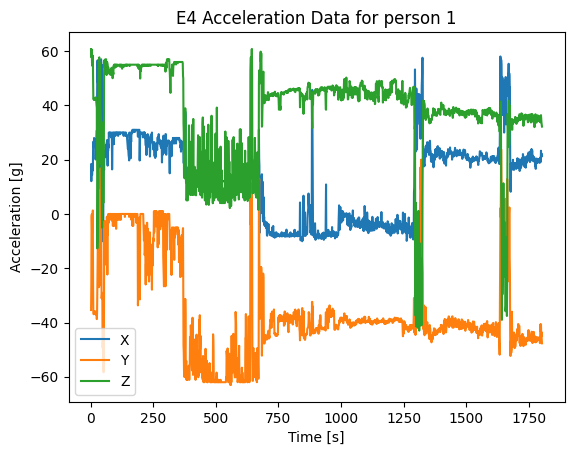

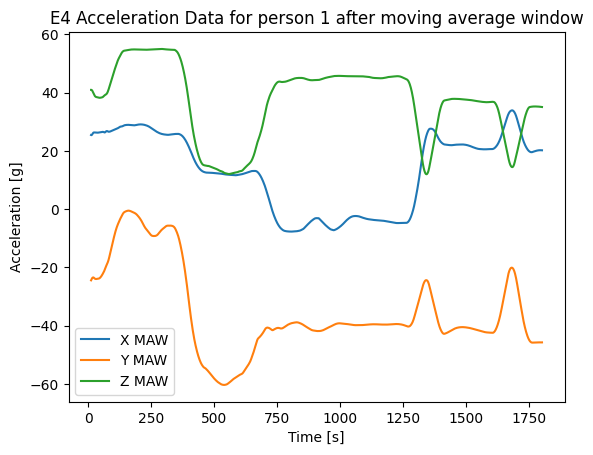

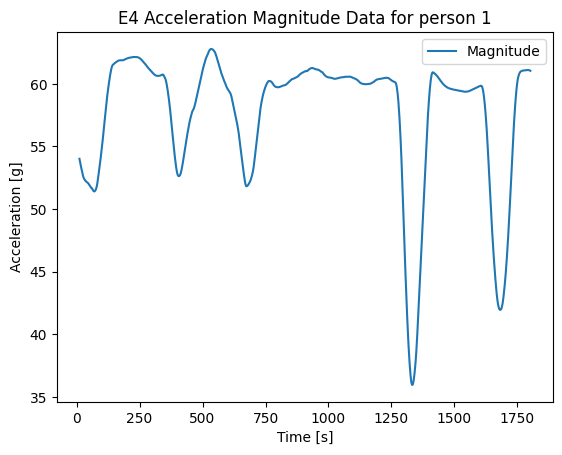

C:\Users\tiitu\AppData\Local\Temp\ipykernel_18468\780225939.py:35: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  E4_start_timestamp = pd.to_datetime(E4_start_timestamp_num, unit='s')


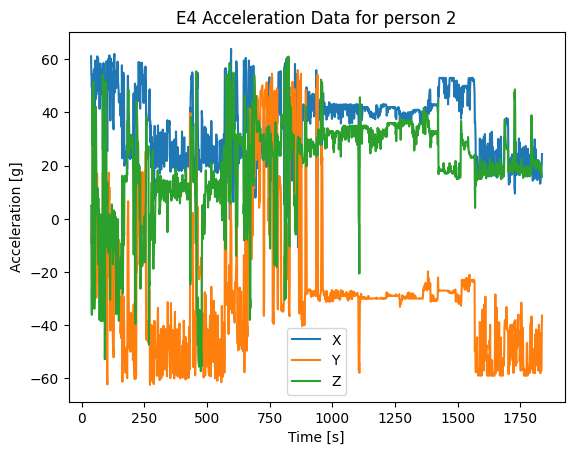

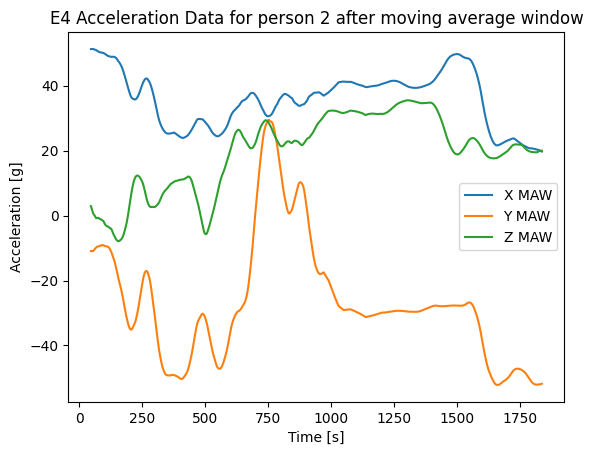

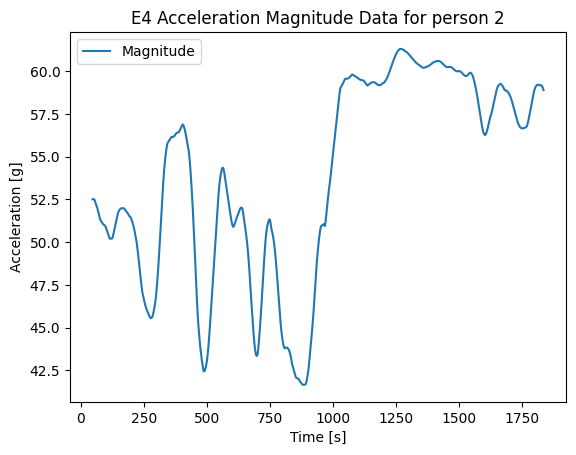

C:\Users\tiitu\AppData\Local\Temp\ipykernel_18468\780225939.py:35: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  E4_start_timestamp = pd.to_datetime(E4_start_timestamp_num, unit='s')


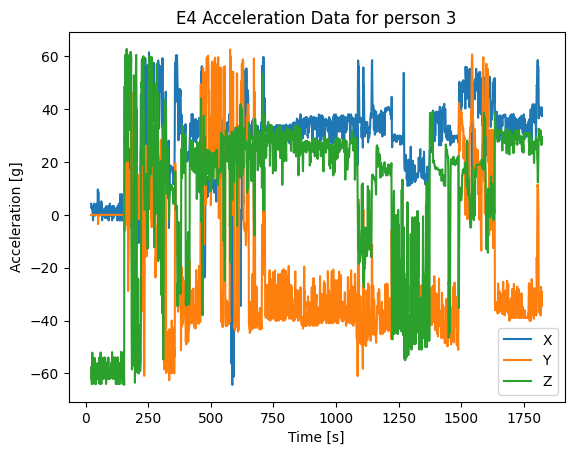

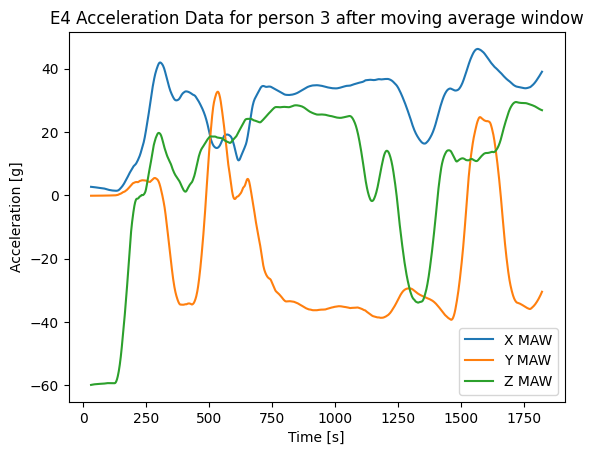

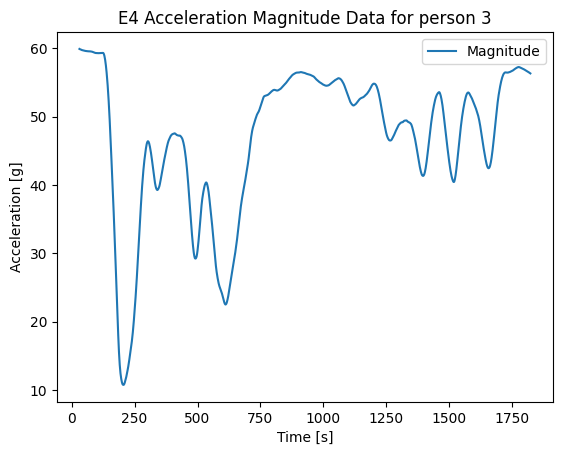

C:\Users\tiitu\AppData\Local\Temp\ipykernel_18468\780225939.py:35: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  E4_start_timestamp = pd.to_datetime(E4_start_timestamp_num, unit='s')


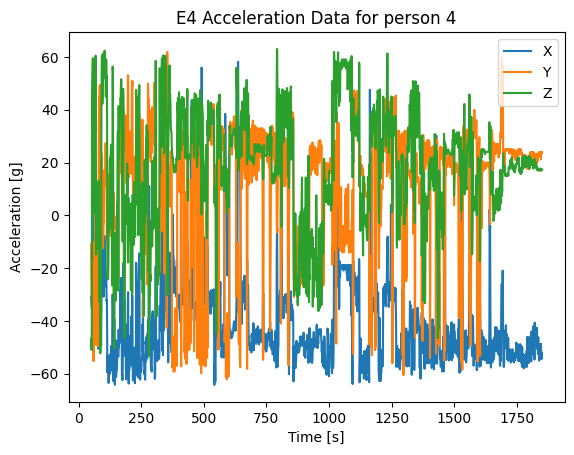

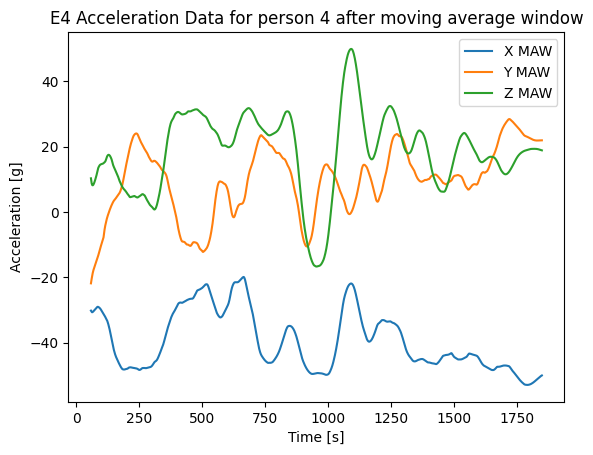

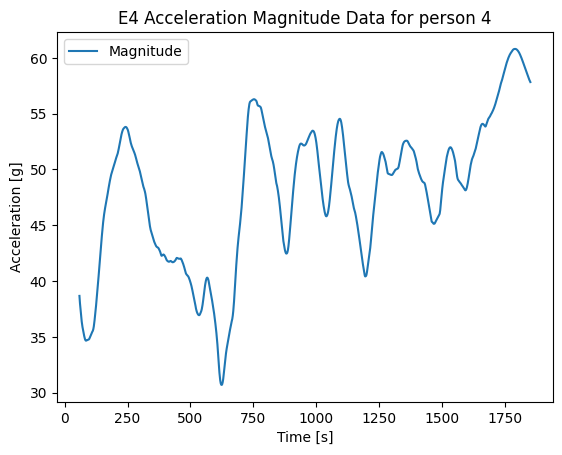

C:\Users\tiitu\AppData\Local\Temp\ipykernel_18468\780225939.py:35: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  E4_start_timestamp = pd.to_datetime(E4_start_timestamp_num, unit='s')


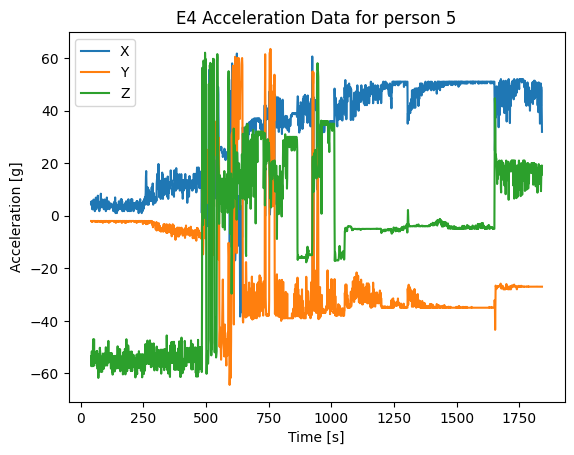

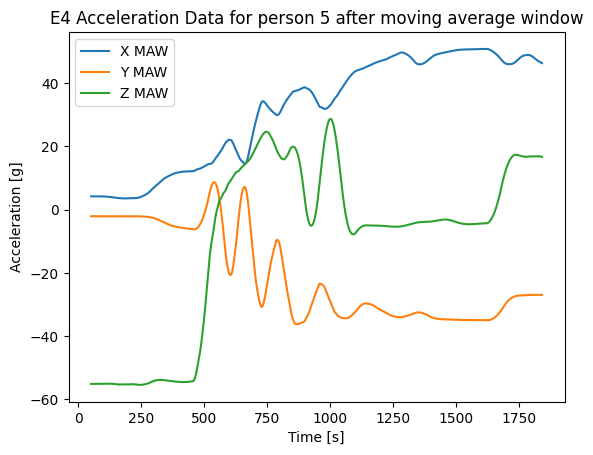

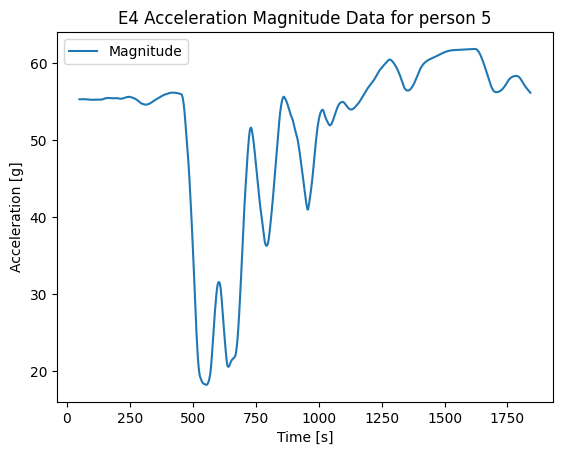

C:\Users\tiitu\AppData\Local\Temp\ipykernel_18468\780225939.py:35: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  E4_start_timestamp = pd.to_datetime(E4_start_timestamp_num, unit='s')


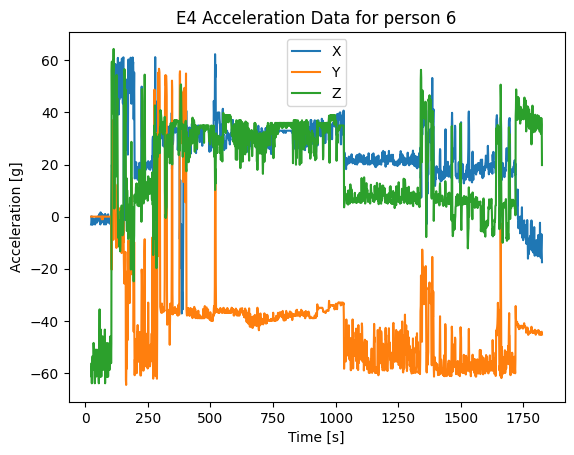

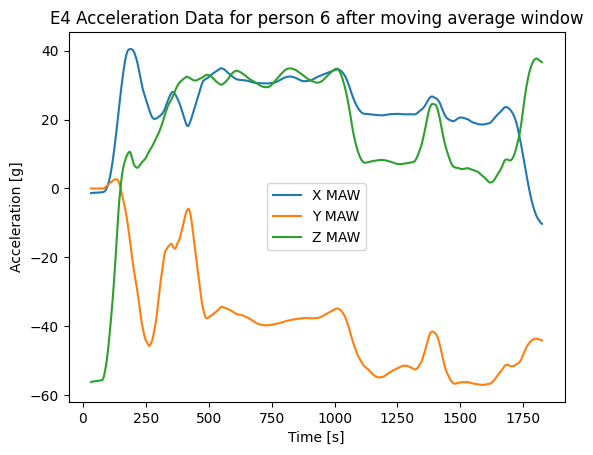

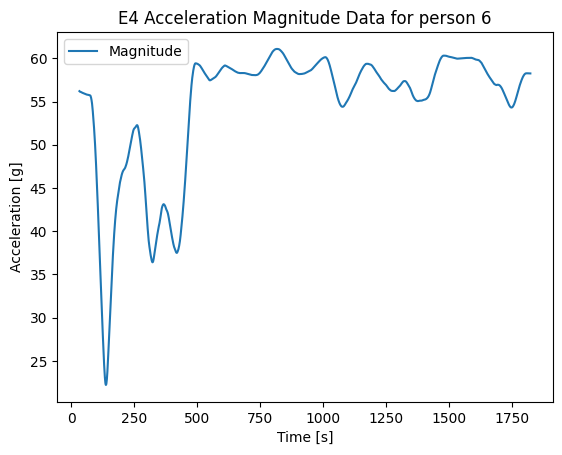

C:\Users\tiitu\AppData\Local\Temp\ipykernel_18468\780225939.py:35: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  E4_start_timestamp = pd.to_datetime(E4_start_timestamp_num, unit='s')


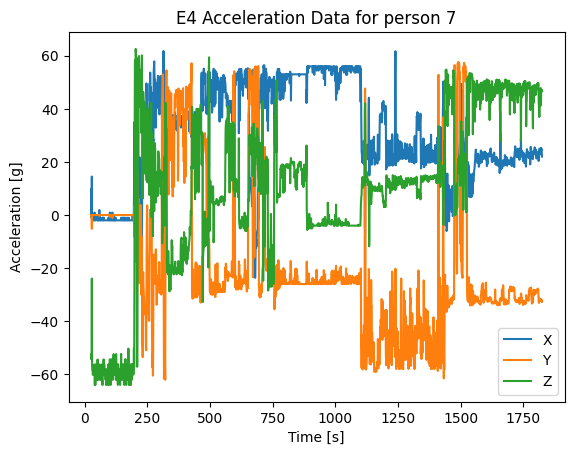

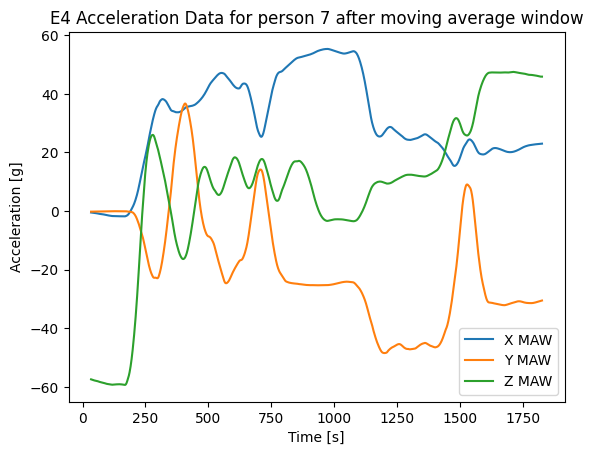

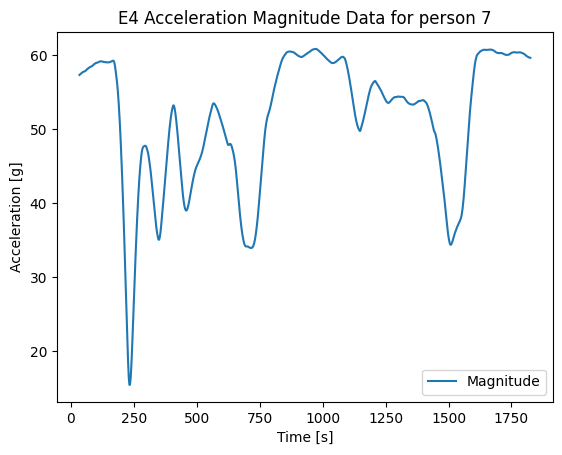

C:\Users\tiitu\AppData\Local\Temp\ipykernel_18468\780225939.py:35: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  E4_start_timestamp = pd.to_datetime(E4_start_timestamp_num, unit='s')


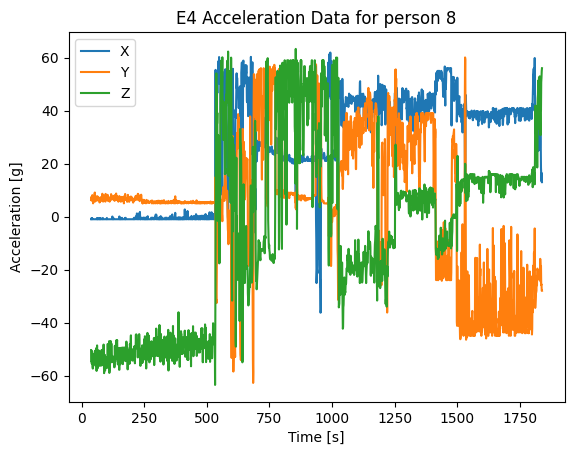

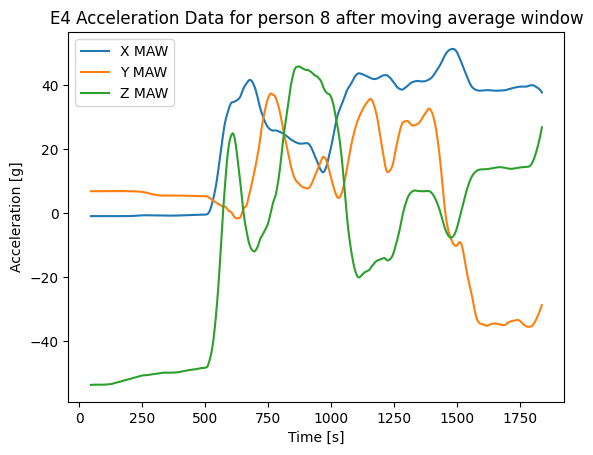

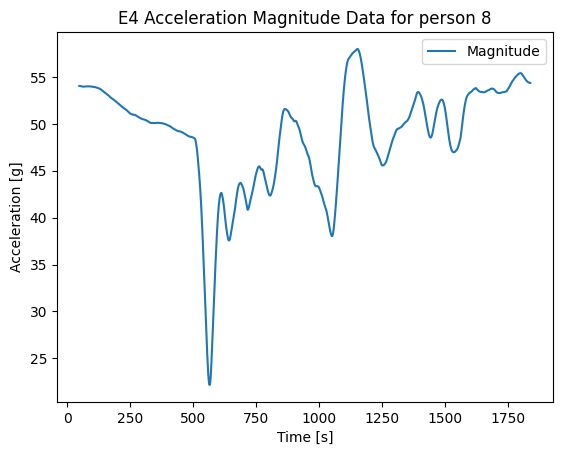

C:\Users\tiitu\AppData\Local\Temp\ipykernel_18468\780225939.py:35: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  E4_start_timestamp = pd.to_datetime(E4_start_timestamp_num, unit='s')


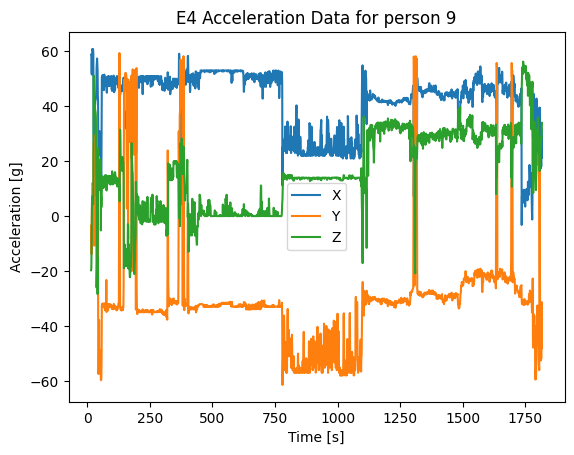

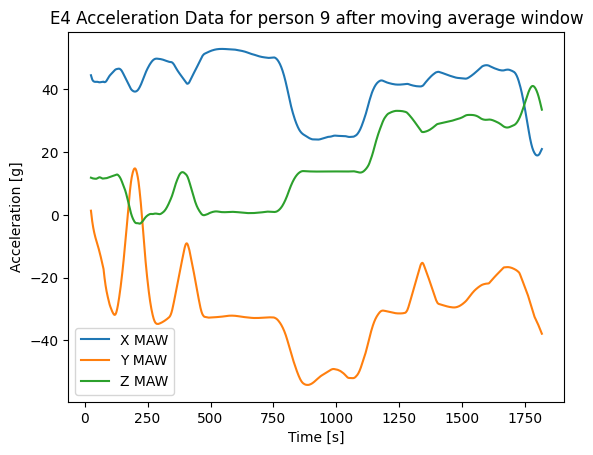

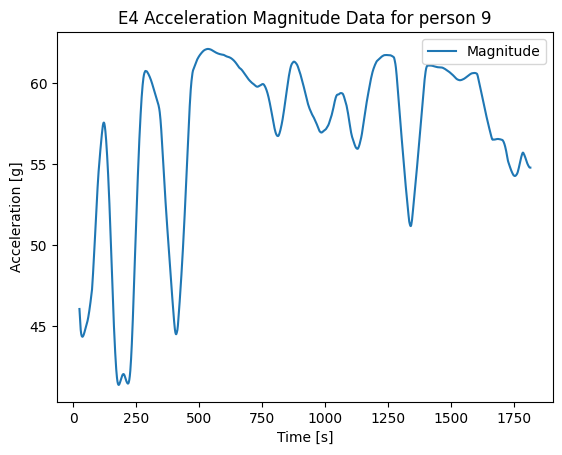

C:\Users\tiitu\AppData\Local\Temp\ipykernel_18468\780225939.py:35: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  E4_start_timestamp = pd.to_datetime(E4_start_timestamp_num, unit='s')


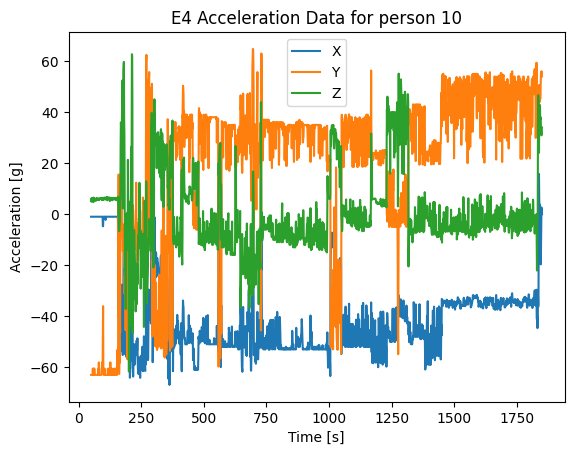

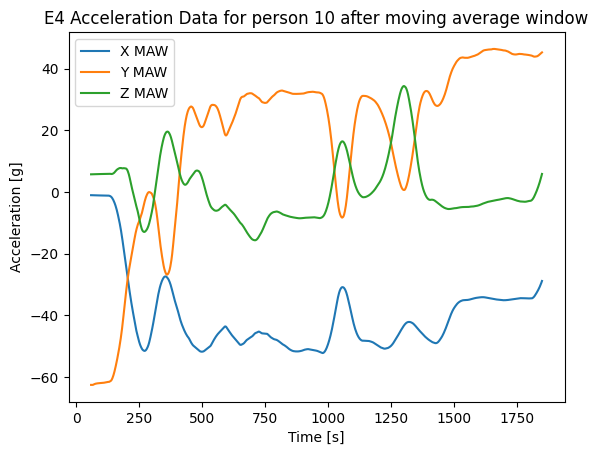

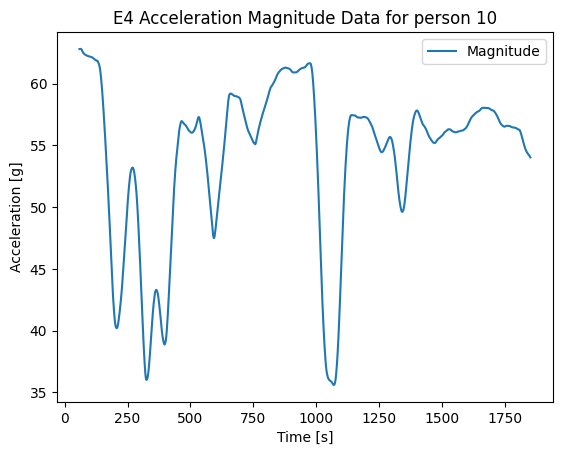

C:\Users\tiitu\AppData\Local\Temp\ipykernel_18468\780225939.py:35: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  E4_start_timestamp = pd.to_datetime(E4_start_timestamp_num, unit='s')


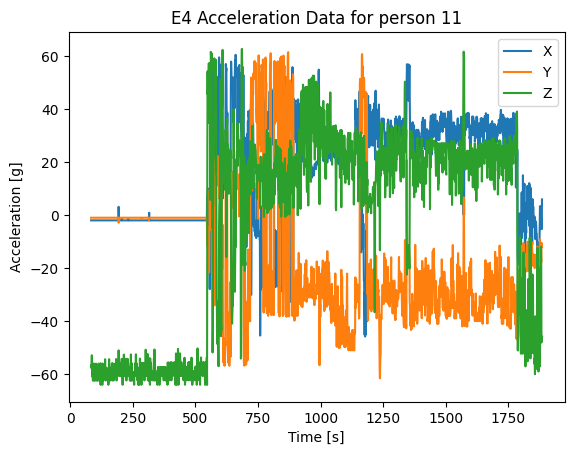

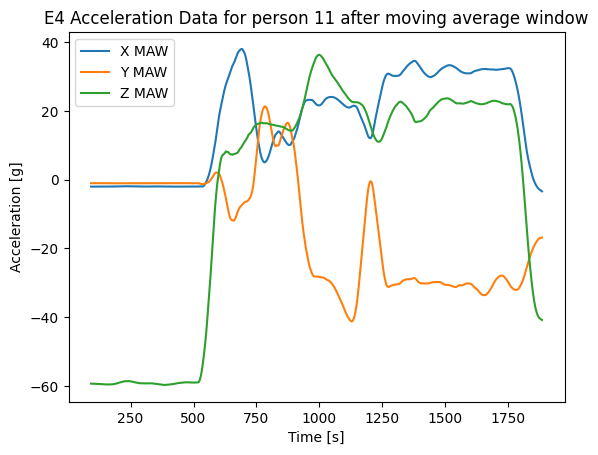

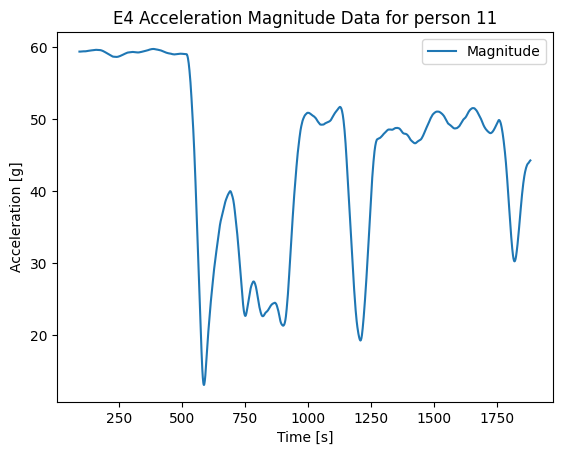

C:\Users\tiitu\AppData\Local\Temp\ipykernel_18468\780225939.py:35: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  E4_start_timestamp = pd.to_datetime(E4_start_timestamp_num, unit='s')


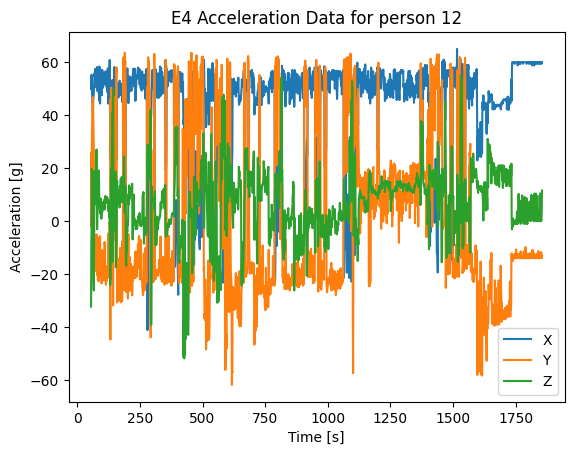

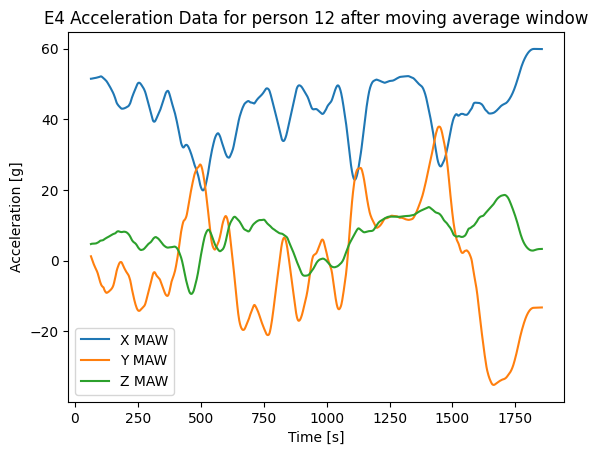

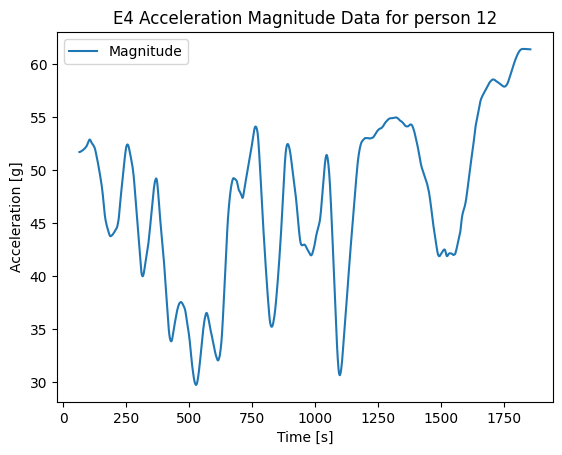

C:\Users\tiitu\AppData\Local\Temp\ipykernel_18468\780225939.py:35: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  E4_start_timestamp = pd.to_datetime(E4_start_timestamp_num, unit='s')


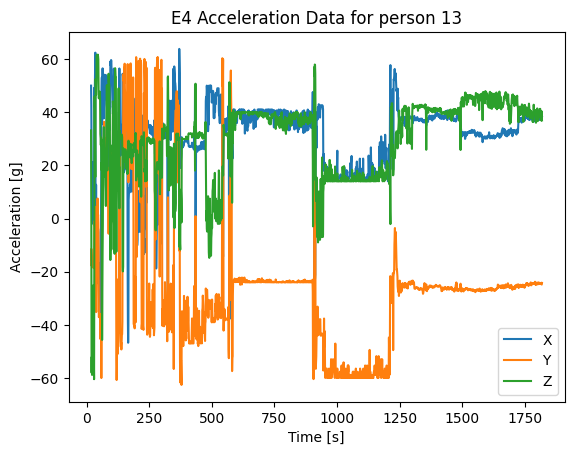

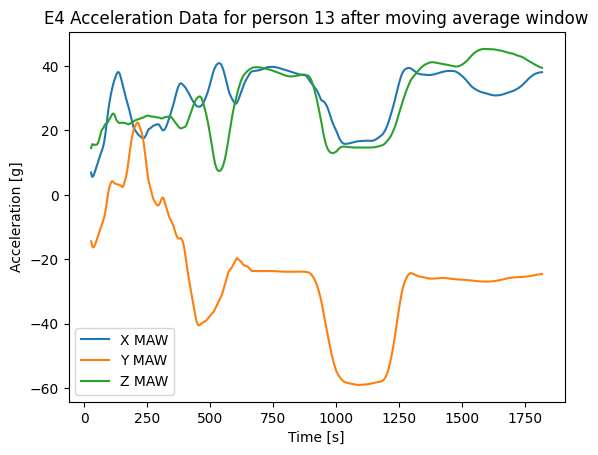

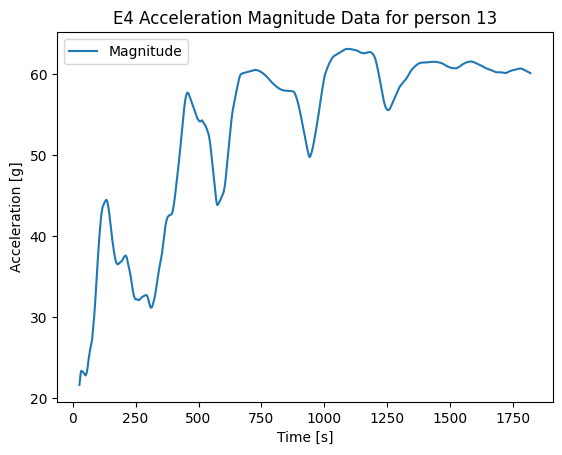

C:\Users\tiitu\AppData\Local\Temp\ipykernel_18468\780225939.py:35: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  E4_start_timestamp = pd.to_datetime(E4_start_timestamp_num, unit='s')


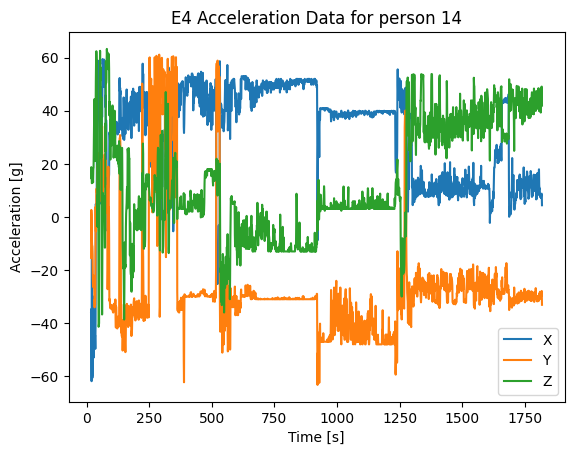

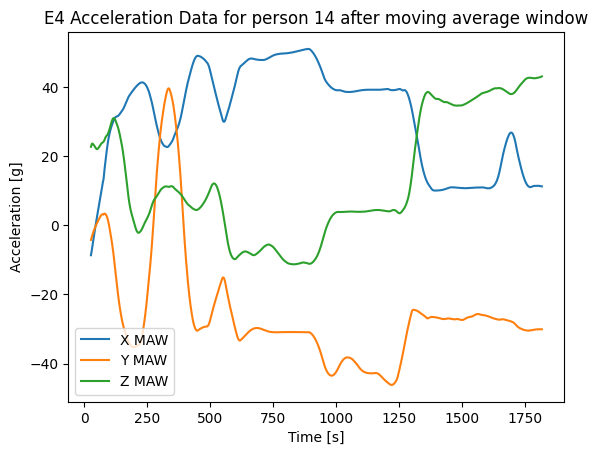

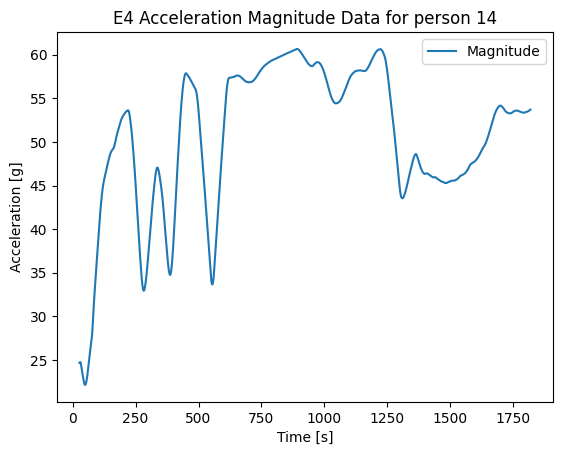

C:\Users\tiitu\AppData\Local\Temp\ipykernel_18468\780225939.py:35: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  E4_start_timestamp = pd.to_datetime(E4_start_timestamp_num, unit='s')


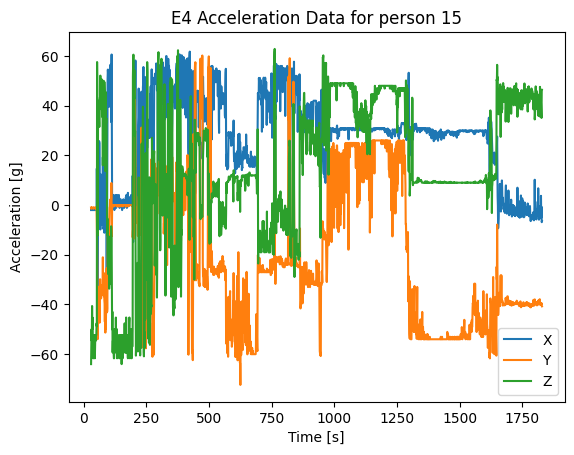

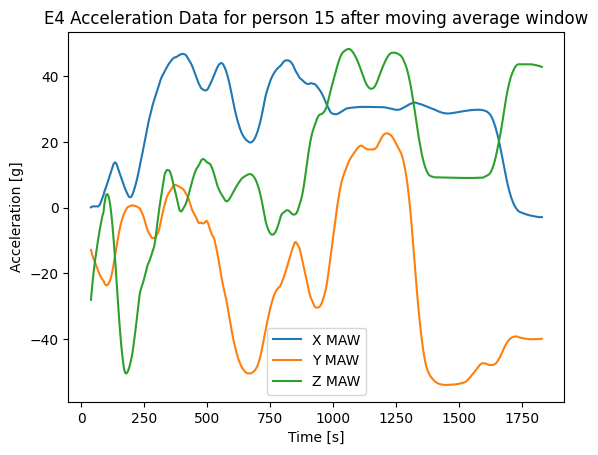

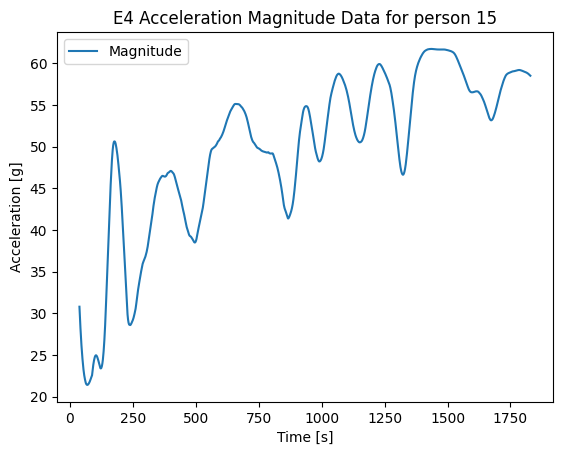

C:\Users\tiitu\AppData\Local\Temp\ipykernel_18468\780225939.py:35: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  E4_start_timestamp = pd.to_datetime(E4_start_timestamp_num, unit='s')


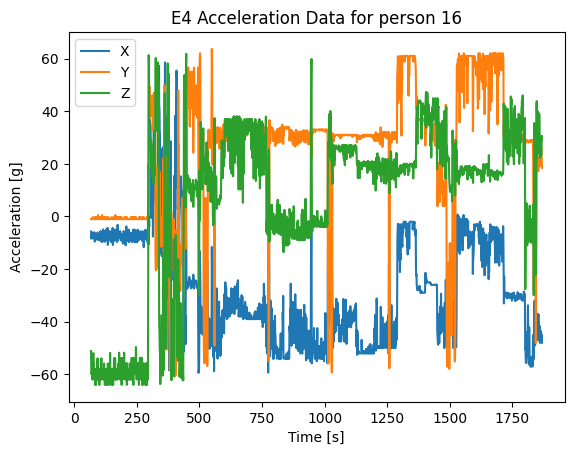

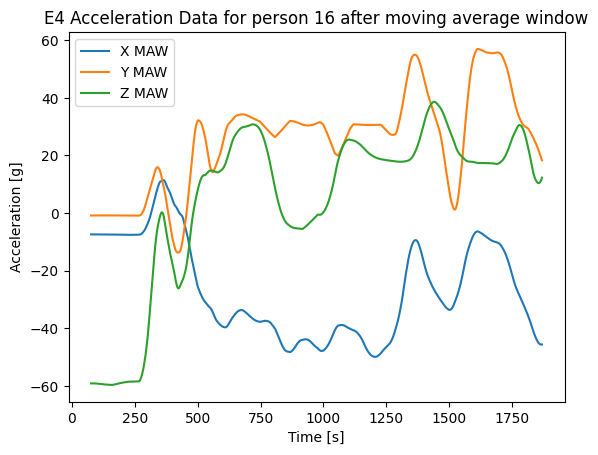

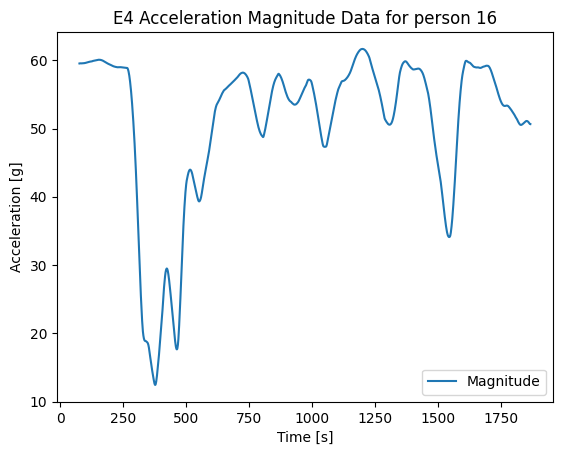

C:\Users\tiitu\AppData\Local\Temp\ipykernel_18468\780225939.py:35: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  E4_start_timestamp = pd.to_datetime(E4_start_timestamp_num, unit='s')


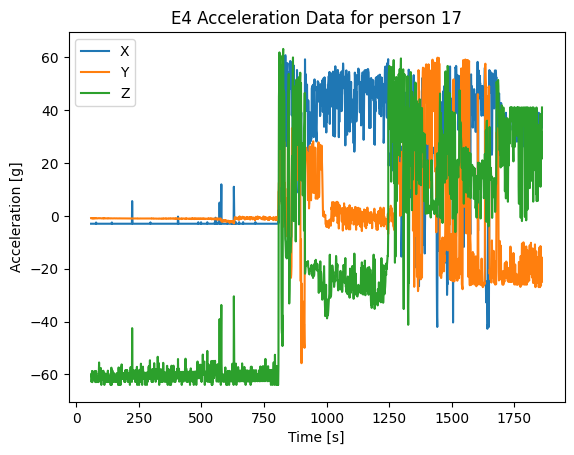

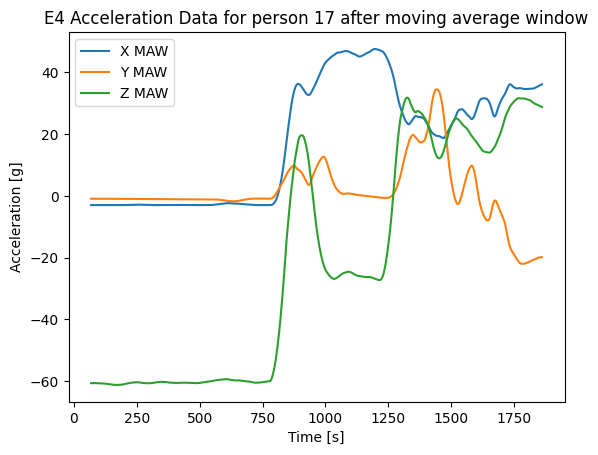

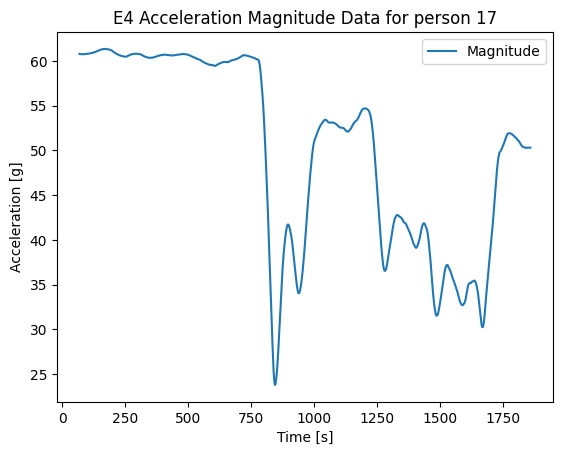

In [11]:
# Complete the ACC data preprocessing for all persons
preprocessed_data = []
for i in range(1, PERSONS+1):
    print("Progress: ", i, "/", PERSONS, end="\r")
    e4_data, VO2_data = sync_acc_with_VO2(i, handle_outliers=True)
    e4_data = central_moving_average(e4_data, 60, plot=True, person=i)
    e4_data_mag = compute_ACC_magnitude(e4_data)
    e4_data['Magnitude'] = e4_data_mag
    # Plot magnitude
    plt.figure()
    plt.plot(e4_data['Magnitude'], label='Magnitude')
    plt.xlabel('Time [s]')
    plt.ylabel('Acceleration [g]')
    plt.legend()
    plt.title(f'E4 Acceleration Magnitude Data for person {i}')
    plt.show()
    preprocessed_data.append(e4_data)

In [12]:
# Save the preprocessed data
for i, participant in enumerate(preprocessed_data):
    os.makedirs(f"../../preprocessed_dataset/P{i+1}", exist_ok=True)
    participant[['Time[s]','X', 'Y', 'Z']].to_pickle(f"../../preprocessed_dataset/P{i+1}/ACC_E4.pkl")